In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Import library yang dibutuhkan

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sqlite3
import pickle
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import defaultdict
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, SimpleRNN, Activation
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from tensorflow.keras.layers import Flatten
from tensorflow.keras import backend as K
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from keras.models import load_model
import re

In [4]:
#Load dataset dari database

db = sqlite3.connect('/content/drive/MyDrive/platinum-challenge/database.db')
data = 'SELECT * FROM data'
data_train = pd.read_sql_query(data, db)
data_train.head()

#df_train = pd.read_csv('train_preprocess.tsv.txt', delimiter='\t',names=['Kalimat','Label'])

data_train.head()

,Kalimat,Label
0,warung ini dimiliki oleh pengusaha pabrik tahu...,positive
1,mohon ulama lurus dan k212 mmbri hujjah partai...,neutral
2,lokasi strategis di jalan sumatra bandung temp...,positive
3,betapa bahagia nya diri ini saat unboxing pake...,positive
4,aduh jadi mahasiswa jangan sombong dong kasih ...,negative


In [5]:
#Melakukan cek distribusi data

data_train['Label'].value_counts()

positive    6416
negative    3436
neutral     1148
Name: Label, dtype: int64

In [6]:
# Oversampling label netral sehingga jumlah data dengan label netral sama dengan jumlah data dengan label negatif

data_neu = data_train[data_train['Label']=='neutral']
data_pos = data_train[data_train['Label']=='positive']
data_neg = data_train[data_train['Label']=='negative']

df_neu = data_neu.sample(data_neg.shape[0], replace = True)

data_train = pd.concat([data_pos, df_neu, data_neg])

# Data Kalimat

neu_kalimat = data_train.loc[data_train['Label'] == 'neutral'].Kalimat.tolist()
pos_kalimat = data_train.loc[data_train['Label'] == 'positive'].Kalimat.tolist()
neg_kalimat = data_train.loc[data_train['Label'] == 'negative'].Kalimat.tolist()

# Data Label
neu_label = data_train.loc[data_train['Label'] == 'neutral'].Label.tolist()
pos_label = data_train.loc[data_train['Label'] == 'positive'].Label.tolist()
neg_label = data_train.loc[data_train['Label'] == 'negative'].Label.tolist()

In [7]:
#Final jumlah data yang digunakan

total_data = neu_kalimat + pos_kalimat + neg_kalimat
labels = neu_label + pos_label + neg_label

print("Neu: %s, Pos: %s, Neg: %s" % (len(neu_kalimat), len(pos_kalimat), len(neg_kalimat)))
print("Total data: %s" % len(total_data))
print("Total labels: %s" % len(labels))

Neu: 3436, Pos: 6416, Neg: 3436
Total data: 13288
Total labels: 13288


In [22]:
#Tokenizer dan pad sequence

max_features = 5000
tokenizer = Tokenizer(num_words=max_features, split=' ', lower=True)
tokenizer.fit_on_texts(total_data)
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
    print("tokenizer.pickle has created!")

X = tokenizer.texts_to_sequences(total_data)

vocab_size = len(tokenizer.word_index)
maxlen = max(len(x) for x in X)

X = pad_sequences(X)
with open('x_pad_sequences.pickle', 'wb') as handle:
    pickle.dump(X, handle, protocol=pickle.HIGHEST_PROTOCOL)
    print("x_pad_sequences.pickle has created!")

tokenizer.pickle has created!
x_pad_sequences.pickle has created!


In [34]:
#Feature extractions pada label

Y = pd.get_dummies(labels)
Y = Y.values

with open('y_labels.pickle', 'wb') as handle:
    pickle.dump(Y, handle, protocol=pickle.HIGHEST_PROTOCOL)
    print("y_labels.pickle has created!")

y_labels.pickle has created!


In [24]:
#Split data train dan data tes dengan porsi 80:20

file = open("x_pad_sequences.pickle",'rb')
X = pickle.load(file)
file.close()

file = open("y_labels.pickle",'rb')
Y = pickle.load(file)
file.close()

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

Cross Validation

In [25]:
# Untuk lebih menyakinkan lagi, kita juga bisa melakukan "Cross Validation"
import numpy as np
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold

kf = KFold(n_splits=5,random_state=42,shuffle=True)

accuracies = []

y = Y

embed_dim = 200
units = 64

for iteration, data in enumerate(kf.split(X), start=1):

    data_train   = X[data[0]]
    target_train = y[data[0]]

    data_test    = X[data[1]]
    target_test  = y[data[1]]


    model = Sequential()
    model.add(Embedding(max_features, embed_dim, input_length=X.shape[1]))
    model.add(LSTM(units, dropout=0.2))
    model.add(Dense(3,activation='softmax'))
    #model.compile(loss = 'binary_crossentropy', optimizer='adam',metrics = ['accuracy'])

    adam = optimizers.Adam(learning_rate = 0.00005)
    model.compile(loss = 'categorical_crossentropy', optimizer = adam, metrics = ['accuracy'])

    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)
    #history = model.fit(X_train, y_train, epochs=10, batch_size=10, validation_data=(X_test, y_test), verbose=0, callbacks=[es])

    history = model.fit(data_train, target_train, epochs=10, batch_size=10,
                        validation_data=(data_test, target_test))

    predictions = model.predict(X_test)
    y_pred = predictions

    # for the current fold only
    accuracy = accuracy_score(y_test.argmax(axis=1), y_pred.argmax(axis=1))

    print("Training ke-", iteration)
    print(classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1)))
    print("======================================================")

    accuracies.append(accuracy)

# rata-rata akurasi dari sekian iterasi-
average_accuracy = np.mean(accuracies)

print()
print()
print()
print("Rata-rata Accuracy: ", average_accuracy)

Epoch 1/10
1063/1063 [==============================] - 45s 40ms/step - loss: 0.8183 - accuracy: 0.6414 - val_loss: 0.6804 - val_accuracy: 0.6986
Epoch 2/10
1063/1063 [==============================] - 10s 9ms/step - loss: 0.6080 - accuracy: 0.7318 - val_loss: 0.5390 - val_accuracy: 0.7961
Epoch 3/10
1063/1063 [==============================] - 10s 10ms/step - loss: 0.4389 - accuracy: 0.8471 - val_loss: 0.4015 - val_accuracy: 0.8653
Epoch 4/10
1063/1063 [==============================] - 11s 11ms/step - loss: 0.3290 - accuracy: 0.8860 - val_loss: 0.3518 - val_accuracy: 0.8672
Epoch 5/10
1063/1063 [==============================] - 9s 8ms/step - loss: 0.2741 - accuracy: 0.9040 - val_loss: 0.3246 - val_accuracy: 0.8811
Epoch 6/10
1063/1063 [==============================] - 8s 8ms/step - loss: 0.2325 - accuracy: 0.9232 - val_loss: 0.3135 - val_accuracy: 0.8890
Epoch 7/10
1063/1063 [==============================] - 9s 8ms/step - loss: 0.2029 - accuracy: 0.9326 - val_loss: 0.3019 - val_ac

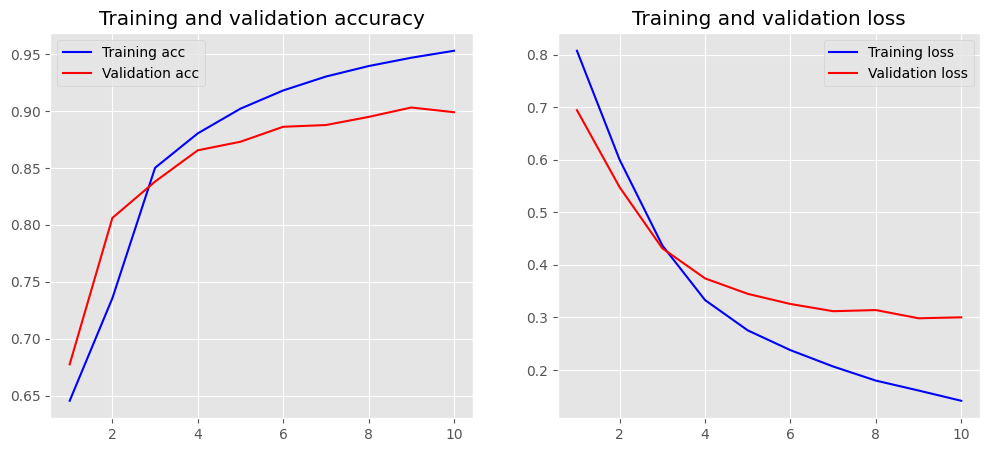

In [26]:
# Membuat visualisasi dari akurasi dan loss dari data training dan data validasi
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

%matplotlib inline
plot_history(history)

In [27]:
# Menyimpan model

model.save('model.h5')
print("Model has created!")

Model has created!


# **Prediction**

In [33]:
input_text = """
mohon ulama lurus dan k212 mmbri hujjah partai apa yang harus diwlh agar suara islam tidak pecah-pecah
"""

def cleansing(sent):
    s = sent.lower()
    s = re.sub(r'[^a-zA-Z0-9]', ' ', s)
    s = re.sub('((www\.[^\s]+)|(https?:\/\/[^\s]+)|(http?:\/\/[^\s]+)|(http[^\s]+))',' ', s) #menghapus semua URL
    s = re.sub(r'(?:\\x[A-Fa-f0-9]{2})+', r'', s) #menghapus \xDD substring
    s = re.sub('[^0-9a-zA-Z]+', ' ', s) #menghilangkan semua karakter yang bukan huruf atau angka dan menggantinya dengan spasi.
    s = re.sub(r'\brt\b',' ', s) #menghapus awalan rt
    s = re.sub('gue','saya', s) # Mengganti kata "gue" dengan kata "saya"
    #s = re.sub(r'\d+', '', s) #menghapus semua angka
    s = re.sub(r'\buser\b',' ', s) #menghapus kata 'user'
    s = re.sub(r':', ' ', s) #menggantikan karakter : dengan spasi
    s = re.sub(' +', ' ', s) #menggantikan satu atau lebih spasi berturut-turut dengan satu spasi
    s = re.sub('\n',' ',s) #menggantikan karakter newline (\n) dengan spasi
    s = re.sub(r'pic.twitter.com.[\w]+', ' ', s) #menghapus semua tautan Twitter (pic.twitter.com)
    s = s.strip() #menghilangkan whitespace di awal dan di akhir teks
    return s

sentiment = ['negative', 'neutral', 'positive']

text = [cleansing(input_text)]
predicted = tokenizer.texts_to_sequences(text)
guess = pad_sequences(predicted, maxlen=X.shape[1])

model = load_model('model.h5')
prediction = model.predict(guess)
polarity = np.argmax(prediction[0])
hasil = sentiment[polarity]

print("Text: %s" % text[0])
print("Sentiment: %s" % sentiment[polarity])

1/1 [==============================] - 0s 468ms/step
Text: mohon ulama lurus dan k212 mmbri hujjah partai apa yang harus diwlh agar suara islam tidak pecah pecah
Sentiment: neutral
